In [56]:
from datetime import datetime, timedelta
import pickle

from package.query import *
from package.plot import *
from package.data_mgt import *
from package.seriealize import *
from package.dic_mgt import *

Input str :  34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['34597, 34818, 34938, 35212, 35339, 35588, 35746', '34599, 34772, 34829, 34901, 35023, 35108, 35240', '34690, 34708, 34781, 34855, 34954, 35026, 35074', '34632, 34620, 34608, 34596, 34584, 34572, 34560', '34209, 34351, 34253, 34538, 34452, 34661', '34662, 34774, 34955, 35086, 35019, 35118, 35169', '34754, 34988, 35203, 35489, 35616, 35872, 36019', '34607, 34717, 34844, 34894, 34935, 35009, 35117', '34490, 34675, 34485, 34554, 34541, 34621, 34532', '34697, 34703, 34675, 34592, 34555, 34618, 34740']
serialized list :  [[34597, 34818, 34938, 35212, 35339, 35588, 35746], [34599, 34772, 34829, 34901, 35023, 35108, 35240], [34690, 34708, 34781, 34855, 34954, 35026, 35074], [34632, 34620, 34608, 34596, 34584, 34572, 34560], [34209, 34351, 34253, 34538, 34452, 34661, 34661], [34662, 34774, 34955, 35086, 35019, 35118, 35169], [34754, 34988, 35203, 35489, 35616, 35872, 36019], [34607, 34717, 34844, 34894, 34935, 35009, 35117]

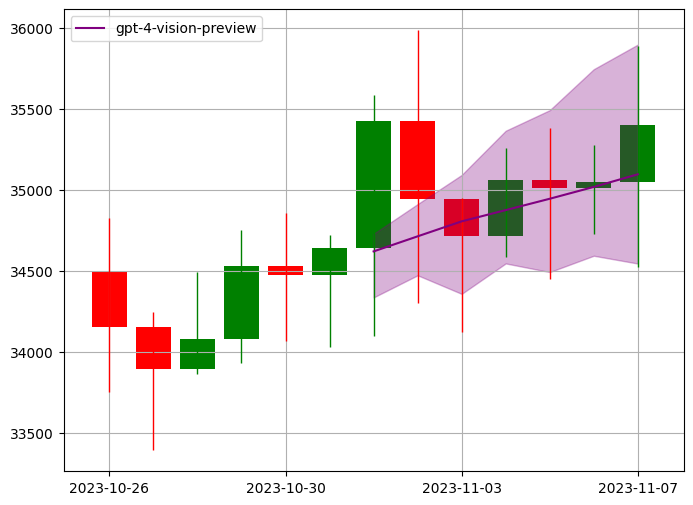

Input str :  29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['34476, 34318, 34253, 34491, 34936, 34886, 35051', '34751, 34840, 34963, 35112, 35206, 35281, 35353', '34855, 34804, 34869, 34907, 34965, 34957, 35022', '34811, 34805, 34988, 35189, 35249, 35358, 35502', '34535, 34550, 34566, 34581, 34597, 34612, 34628', '34729, 34931, 35101, 35231, 35462, 35560, 35714', '34995, 34901, 35231, 34834, 34874, 35054, 35216', '34661, 34704, 34721, 34741, 34746, 34753, 34759', '34683, 34711, 34626, 34566, 34623, 34735, 34890', '34783, 35114, 34867, 34915, 35242, 35313, 35421']
serialized list :  [[34476, 34318, 34253, 34491, 34936, 34886, 35051], [34751, 34840, 34963, 35112, 35206, 35281, 35353], [34855, 34804, 34869, 34907, 34965, 34957, 35022], [34811, 34805, 34988, 35189, 35249, 35358, 35502], [34535, 34550, 34566, 34581, 34597, 34612, 34628], [34729, 34931, 35101, 35231, 35462, 35560, 35714], [34995, 34901, 35231, 34834, 34874, 35054, 35216], 

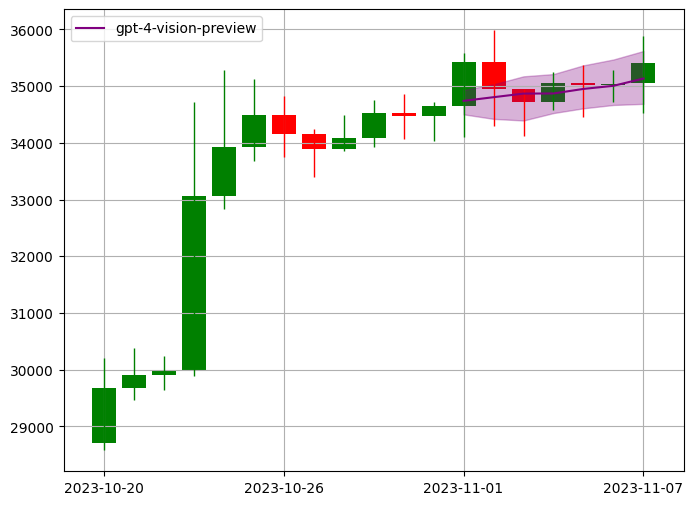

Input str :  27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['34751, 34902, 35188, 35247, 35412, 35589, 35662', '34610, 34953, 34829, 34840, 34961, 35002, 35020', '34691, 34786, 34906, 35221, 35510, 35945, 36220', '34672, 34748, 34749, 34683, 34656, 34698, 34747', '34623, 34616, 34589, 34573, 34567, 34562, 34559', '34609, 34863, 35108, 35058, 35223, 35285, 35529', '34432, 34570, 33940, 33220, 33095, 33110, 33850', '34696, 34936, 35172, 35192, 35231, 35271, 35513', '34907, 35221, 35478, 35673, 35830, 35972, 36094', '34447, 34418, 34813, 34792, 34225, 34084, 35189']
serialized list :  [[34751, 34902, 35188, 35247, 35412, 35589, 35662], [34610, 34953, 34829, 34840, 34961, 35002, 35020], [34691, 34786, 34906, 35221, 35510, 35945, 36220], [34672, 34748, 34749, 34683, 34656, 34698, 34747], [34623, 34616, 34589, 34573, 34567, 34562, 34559], [34609, 34863, 351

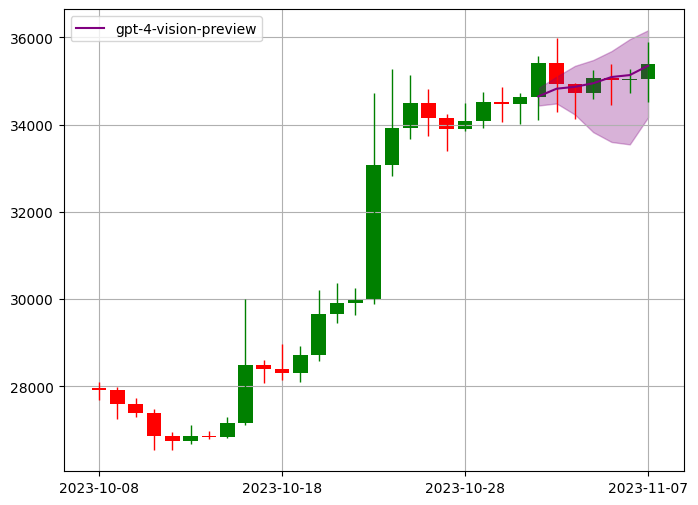

Input str :  26523, 26600, 26560, 26528, 26763, 27210, 27125, 26568, 26580, 26576, 26248, 26304, 26221, 26372, 27022, 26907, 26963, 27993, 27495, 27427, 27779, 27411, 27932, 27957, 27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['34629, 34637, 34566, 33824, 33291, 32721, 32618', '34695, 34582, 34525, 34503, 34487, 34478, 34473', '34695, 34523, 34681, 34658, 34567, 34550, 34622', '34784, 35223, 35702, 35708, 35230, 35372, 35839', '34456, 34375, 35220, 35100, 35370, 35780, 35695', '35147, 35127, 34905, 34900, 35012, 35422, 35511', '34702, 35063, 35205, 35272, 34915, 35585, 35930', '34601, 34357, 34193, 34222, 34156, 34108, 34160', '34689, 34522, 34590, 34636, 34781, 34817, 35012', '34604, 34604, 34936, 34975, 35263, 35274, 35294']
serialized list :  [[34629, 34637, 34566, 33824, 33291, 32721, 32618], [34695, 34582, 34525, 34503, 34487, 34478, 34473], [34

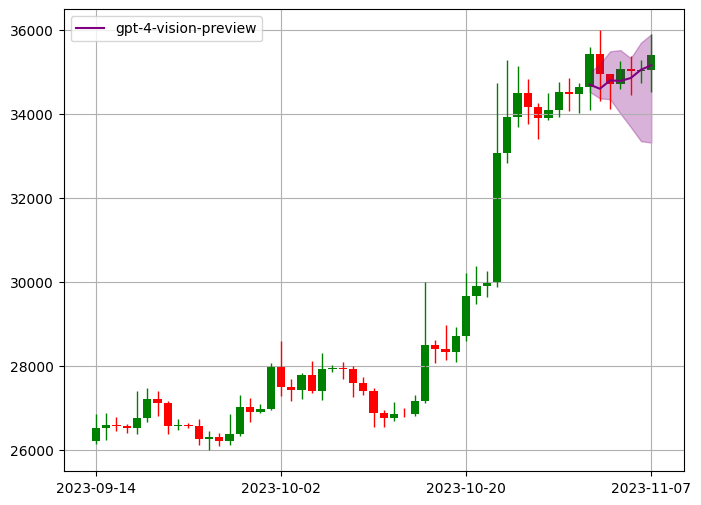

Input str :  29314, 29353, 29281, 29232, 29706, 29185, 29193, 29112, 29071, 29087, 29210, 29770, 29581, 29454, 29425, 29430, 29303, 29430, 29199, 28729, 26624, 26054, 26100, 26190, 26127, 26055, 26433, 26179, 26059, 26017, 26101, 26119, 27717, 27300, 25940, 25805, 25870, 25971, 25826, 25792, 25759, 26254, 25910, 25902, 25841, 25162, 25840, 26222, 26523, 26600, 26560, 26528, 26763, 27210, 27125, 26568, 26580, 26576, 26248, 26304, 26221, 26372, 27022, 26907, 26963, 27993, 27495, 27427, 27779, 27411, 27932, 27957, 27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['34567, 34476, 34492, 34386, 34854, 34911, 35135', '34620, 34297, 33826, 33755, 33629, 33806, 33860', '34484, 34356, 34502, 34368, 34402, 34455, 34615', '34791, 34732, 34622, 34883, 35265, 35336, 35599', '34632, 34558, 34729, 34396, 34349, 34804, 34785', '34662, 34697, 34604, 34529, 34783, 34422, 3

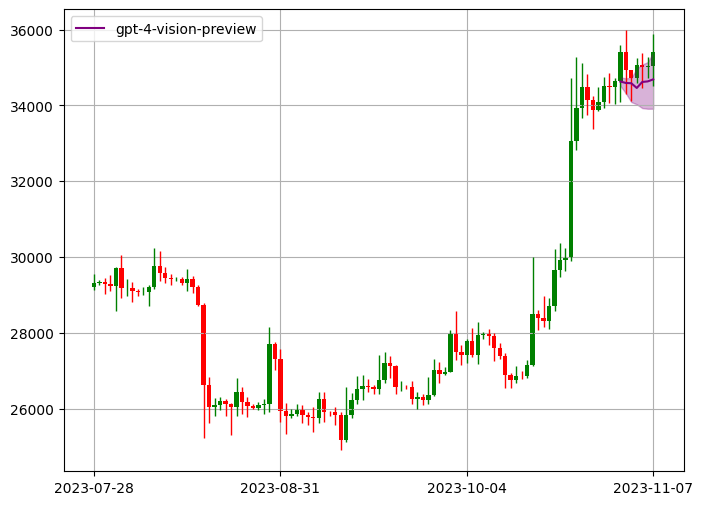

Input str :  27591, 27511, 28301, 28416, 29473, 29313, 29231, 29233, 28069, 28670, 29026, 28839, 29507, 28850, 28431, 27670, 27629, 27599, 26970, 26796, 26776, 26919, 27162, 27034, 27406, 26821, 26881, 27103, 26748, 26850, 27220, 26329, 26474, 26706, 26855, 28065, 27737, 27695, 27211, 26818, 27243, 27070, 27116, 25729, 27230, 26340, 26499, 26478, 25842, 25926, 25905, 25934, 25129, 25597, 26344, 26517, 26340, 26844, 28308, 29995, 29885, 30690, 30528, 30463, 30268, 30693, 30077, 30447, 30472, 30586, 30617, 31156, 30767, 30505, 29896, 30345, 30285, 30161, 30412, 30622, 30380, 31455, 30313, 30290, 30233, 30139, 29860, 29910, 29800, 29902, 29794, 30084, 29177, 29229, 29352, 29223, 29314, 29353, 29281, 29232, 29706, 29185, 29193, 29112, 29071, 29087, 29210, 29770, 29581, 29454, 29425, 29430, 29303, 29430, 29199, 28729, 26624, 26054, 26100, 26190, 26127, 26055, 26433, 26179, 26059, 26017, 26101, 26119, 27717, 27300, 25940, 25805, 25870, 25971, 25826, 25792, 25759, 26254, 25910, 25902, 25841, 

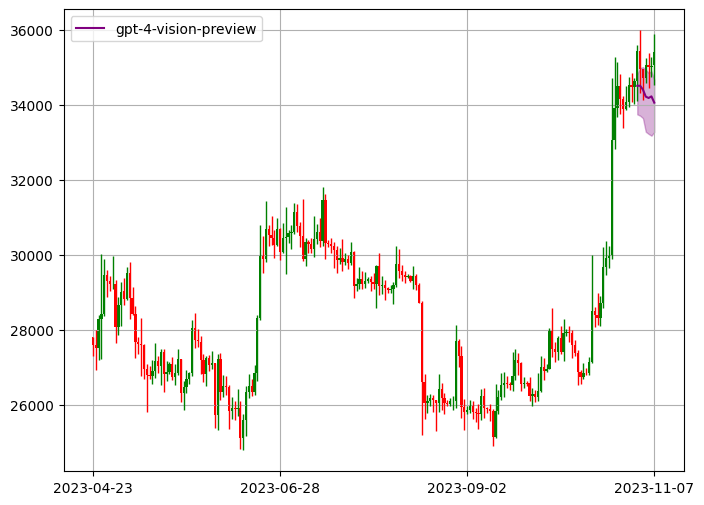

In [57]:
ending_predict_date = '2023-11-01'
ending_dates = ['2023-11-04', '2023-11-06', '2023-11-08']
index_save = 0
savefig = "naive/"
dict_error_naive = {"input_length" : {6: {"Mae": None, "Mse": None},
                                12: {"Mae": None, "Mse": None},
                                24: {"Mae": None, "Mse": None},
                                48: {"Mae": None, "Mse": None},
                                96: {"Mae": None, "Mse": None},
                                192: {"Mae": None, "Mse": None}}}

for input_length in [6, 12, 24, 48, 96, 192] :

    ending_predict_date_num = datetime.strptime(ending_predict_date, '%Y-%m-%d')
    new_date = ending_predict_date_num - timedelta(days=input_length)

    start_date = new_date.strftime('%Y-%m-%d')
    end_date = ending_dates[-1]

    df_raw, train, test = get_data_set("datasets/BTC_Daily_ohlc.csv", input_length, start_date, end_date)
    input_str = str_convert(train.values)

    print("Input str : ", input_str)
    list_response = request_gpt(input_str)
    print("GPT Answer : ", list_response)

    final_dic_int_list = basic_seriealize(list_response)
    print("serialized list : ", final_dic_int_list)

    full_Mae_dict, full_Mse_dict = MAE_MSE_calculator(final_dic_int_list, df_raw, input_length)
    dict_error_naive["input_length"][input_length]["Mae"] = full_Mae_dict
    dict_error_naive["input_length"][input_length]["Mse"] = full_Mse_dict

    with open('pickle/dic_error_naive.pkl', 'wb') as fichier:
        pickle.dump(dict_error_naive, fichier)

    index_save += 1
    current_folder = savefig + str(index_save)
    plot_preds_candles(df_raw, train, test, final_dic_int_list, "gpt-4-vision-preview", show_samples=False, savefig = current_folder)


In [58]:
with open('pickle/dic_error_naive.pkl', 'rb') as fichier:
    dict_error_naive = pickle.load(fichier)

dic_error_3_naive = {"input_length" : {6: {"Mae": None, "Mse": None},
                                12: {"Mae": None, "Mse": None},
                                24: {"Mae": None, "Mse": None},
                                48: {"Mae": None, "Mse": None},
                                96: {"Mae": None, "Mse": None},
                                192: {"Mae": None, "Mse": None}}}
dic_error_5_naive = {"input_length" : {6: {"Mae": None, "Mse": None},
                                12: {"Mae": None, "Mse": None},
                                24: {"Mae": None, "Mse": None},
                                48: {"Mae": None, "Mse": None},
                                96: {"Mae": None, "Mse": None},
                                192: {"Mae": None, "Mse": None}}}
dic_error_7_naive = {"input_length" : {6: {"Mae": None, "Mse": None},
                                12: {"Mae": None, "Mse": None},
                                24: {"Mae": None, "Mse": None},
                                48: {"Mae": None, "Mse": None},
                                96: {"Mae": None, "Mse": None},
                                192: {"Mae": None, "Mse": None}}}


dic_mgt(dict_error_naive, dic_error_3_naive, dic_error_5_naive, dic_error_7_naive)
print(dic_error_3_naive)


{'input_length': {6: {'Mae': 425.35266528193114, 'Mse': 282987.8642459427}, 12: {'Mae': 381.6779681227087, 'Mse': 219758.5242822791}, 24: {'Mae': 439.27402472504417, 'Mse': 291181.79838664905}, 48: {'Mae': 473.70220329760286, 'Mse': 295872.48030382703}, 96: {'Mae': 459.8140334905964, 'Mse': 299255.1220483808}, 192: {'Mae': 688.4108981079328, 'Mse': 677257.9384150751}}}


In [59]:
table_display(dic_error_3_naive)
table_display(dic_error_5_naive)
table_display(dic_error_7_naive)

  input_length      Mae     Mse
--------------  -------  ------
             6  425.353  282988
            12  381.678  219759
            24  439.274  291182
            48  473.702  295872
            96  459.814  299255
           192  688.411  677258
  input_length      Mae     Mse
--------------  -------  ------
             6  377.434  223551
            12  332.869  168387
            24  463.467  377630
            48  470.621  334994
            96  483.711  336462
           192  775.891  863506
  input_length      Mae               Mse
--------------  -------  ----------------
             6  388.759  230123
            12  322.622  156971
            24  506.176  442242
            48  541.223  517986
            96  530.871  409387
           192  887.308       1.10028e+06


Input str :  -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['186, -251, 408, 316, -274, 733, -234', '77, 28, 264, 109, 475, 212, 716', '-97, -28, 180, 195, -124, -67,', '-23, 82, -59, 119, -85, 152, -124', '92, -47, 137, -112, 182, -177, 227', '5, 107, 12, 65', '96, -76, 160, 15, -136, 231', '42, 49, -121, 55, -177, 78, 179', '114, 190, 41, 205, -33, 218', '92, 163, 39, 108, 184, 60, 128']
error in serialization
int list return
[[186, -251, 408, 316, -274, 733, -234], [77, 28, 264, 109, 475, 212, 716], [-23, 82, -59, 119, -85, 152, -124], [92, -47, 137, -112, 182, -177, 227], [5, 107, 12, 65, 65, 65, 65], [96, -76, 160, 15, -136, 231, 231], [42, 49, -121, 55, -177, 78, 179], [114, 190, 41, 205, -33, 218, 218], [92, 163, 39, 108, 184, 60, 128]]
int list, close
[[35285.056486146874, 34399.40156834459, 35802.89715233305, 36934.26870234677, 35922.26973990247, 38555.372111837314, 37653.17640442032], [34907.47243382113, 35005.213356635824, 35929.35098925101, 36320.98091503385, 38046.2275084979

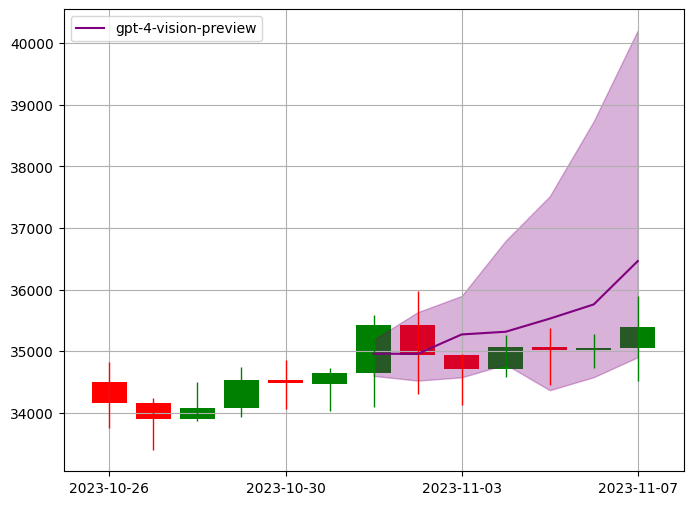

Input str :  333, 81, 28, 1026, 257, 169, -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['-132, 4, -119, 137, 120, -136, 8', '333, -9, -10, 333, 81, 28', '809, 202, 324, -196, -172, 152, 227', '-120, 11, -210, 66, 42, -330, 136', '157, -26, 40, 171, -37, 32, 185', '122, -8, 40, 114, -1, 32', '-118, 37, -6, 250, -64, 163, -144', '-18, -7, 25, 60, 2, 17', '108, 25, -40, 29, 40, -19, -2', "It's not possible to predict the next terms of the sequence without knowing the pattern or rule governing the sequence. The sequence provided does not follow any obvious mathematical or logical pattern that can be discerned from the given numbers. Therefore, I am unable to provide the next terms in the sequence."]
error in serialization
int list return
[[-132, 4, -119, 137, 120, -136, 8], [333, -9, -10, 333, 81, 28, 28], [809, 202, 324, -196, -172, 152, 227], [-120, 11, -210, 66, 42, -330, 136], [157, -26, 40, 171, -37, 32, 185], [122, -8, 40, 114, -1, 32, 32], [-118, 37, -6, 250, -64, 163, -144], [-18, -

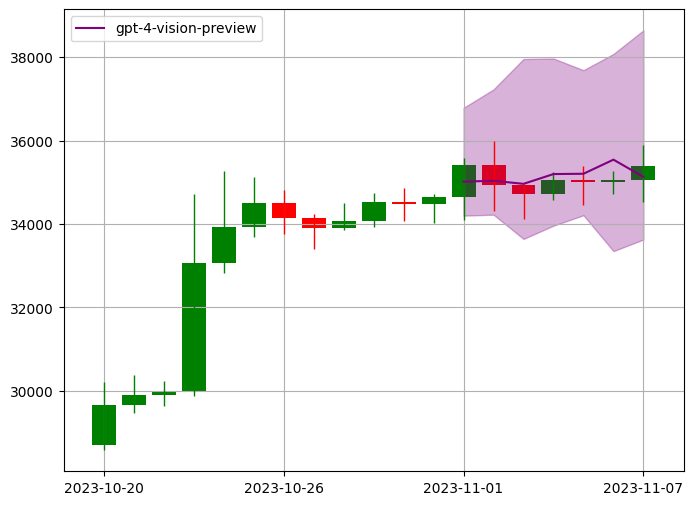

Input str :  -14, -117, -73, -188, -43, 39, -4, 113, 496, -37, -27, 139, 333, 81, 28, 1026, 257, 169, -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['-139, -224, -108, -195, -63, 19, -24', '1048, 323, 136, 132, -231, -174, 96', '-97, -111, 31, 194, 89, 37, -44', '53, 160, -12, 29, 116, -28', '160, -39, 7, 186, 340, 88, 40', '423, -84, -2, 217, 609, 159, 85', '273, 106, -5, 132, -166, -205, 63', '319, 49, 70, 142, -57, 7, 255', '-3, -26, 215, 574, 177, 190, 2093', '159, 240, -64, -52, 192, 376, 112']
int list return
[[-139, -224, -108, -195, -63, 19, -24], [1048, 323, 136, 132, -231, -174, 96], [-97, -111, 31, 194, 89, 37, -44], [53, 160, -12, 29, 116, -28, -28], [160, -39, 7, 186, 340, 88, 40], [423, -84, -2, 217, 609, 159, 85], [273, 106, -5, 132, -166, -205, 63], [319, 49, 70, 142, -57, 7, 255], [-3, -26, 215, 574, 177, 190, 2093], [159, 240, -64, -52, 192, 376, 112]]
int list, close
[[34159.23247691874, 33394.06566943576, 33033.409760205854, 32389.25826988184, 32185.205942781588, 3224

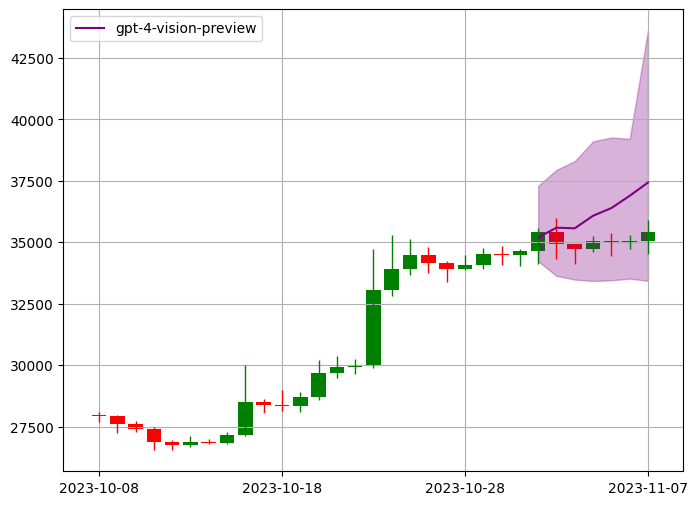

Input str :  115, 29, -15, -12, 89, 167, -31, -205, 5, -1, -123, 22, -32, 58, 246, -42, 21, 382, -178, -25, 128, -133, 190, 9, -14, -117, -73, -188, -43, 39, -4, 113, 496, -37, -27, 139, 333, 81, 28, 1026, 257, 169, -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['-135, 168, 712, -109, -88, 213, 178', '-58, -128, -67, 71, 24, 144, 620', '-164, 19, 365, -74, -72, 189, 1799', '-214, -41, 310, -112, -174, 95, 140', '-202, -44, 233, 509, 202, 427, 1894', '-224, -23, 228, 144, -180, 73, 87', '-101, -29, -44, 152, 82, 38, 2085', '-249, -74, 288, 1729, 695, 487, -292', '207, -12, -9, 265, 329, 172, 65', '-57, -143, 89, 34, 23, -168, -211']
int list return
[[-135, 168, 712, -109, -88, 213, 178], [-58, -128, -67, 71, 24, 144, 620], [-164, 19, 365, -74, -72, 189, 1799], [-214, -41, 310, -112, -174, 95, 140], [-202, -44, 233, 509, 202, 427, 1894], [-224, -23, 228, 144, -180, 73, 87], [-101, -29, -44, 152, 82, 38, 2085], [-249, -74, 288, 1729, 695, 487, -292], [207, -12, -9, 265, 329, 172, 65], [-57,

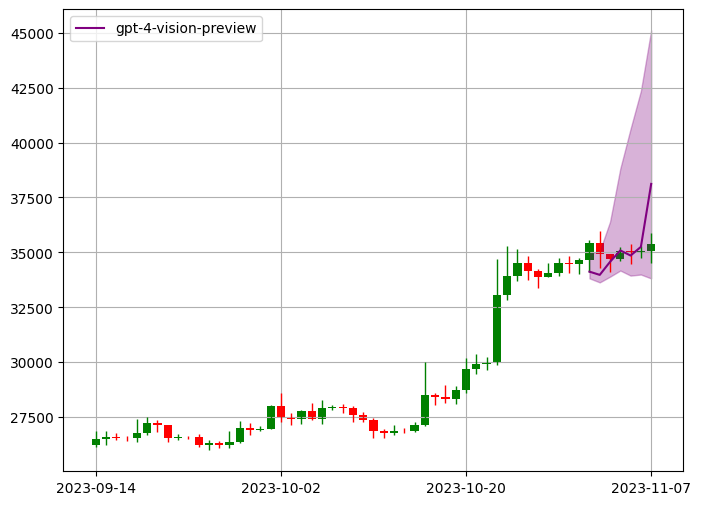

Input str :  31, 13, -25, -17, 162, -175, 3, -28, -14, 5, 42, 192, -64, -43, -10, 2, -43, 43, -79, -161, -733, -214, 18, 35, -24, -27, 145, -96, -46, -16, 32, 7, 612, -150, -498, -52, 25, 39, -56, -13, -12, 192, -131, -3, -23, -263, 269, 148, 115, 29, -15, -12, 89, 167, -31, -205, 5, -1, -123, 22, -32, 58, 246, -42, 21, 382, -178, -25, 128, -133, 190, 9, -14, -117, -73, -188, -43, 39, -4, 113, 496, -37, -27, 139, 333, 81, 28, 1026, 257, 169, -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['-97, -141, 163, -78, -85, 83, 172', '-29, -104, -46, 37, -3, -45, 164', '-175, -258, -62, 18, -1, 71, 404', '79, -56, -23, -89, 31, 13, -25', '-62, -38, -72, -5, 251, 35, 134', '-112, -7, -49, 262, -171, 98, -278', '-133, 124, 21, -5, 106, -48, -58', '624, -290, -132, -135, 63, 37, 142', '-117, -61, -143, 30, 81, 242, 27', '-581, -32, 32, -5, -121, 291, 202']
int list return
[[-97, -141, 163, -78, -85, 83, 172], [-29, -104, -46, 37, -3, -45, 164], [-175, -258, -62, 18, -1, 71, 404], [79, -56, -23, -89, 

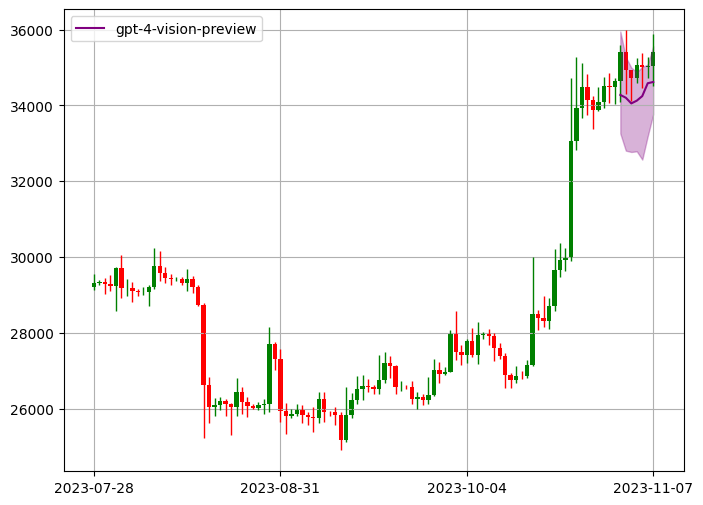

Input str :  -81, -29, 287, 41, 372, -55, -28, 1, -399, 214, 124, -65, 232, -222, -145, -268, -15, -11, -228, -64, -8, 53, 91, -47, 137, -213, 22, 83, -131, 38, 138, -327, 55, 88, 56, 451, -117, -15, -175, -144, 158, -64, 17, -511, 584, -327, 61, -8, -240, 33, -8, 11, -311, 187, 292, 65, -67, 192, 545, 596, -37, 269, -52, -21, -64, 140, -200, 123, 8, 37, 10, 176, -125, -85, -199, 150, -20, -41, 83, 69, -79, 354, -363, -7, -19, -31, -92, 17, -37, 34, -36, 97, -302, 18, 42, -44, 31, 13, -25, -17, 162, -175, 3, -28, -14, 5, 42, 192, -64, -43, -10, 2, -43, 43, -79, -161, -733, -214, 18, 35, -24, -27, 145, -96, -46, -16, 32, 7, 612, -150, -498, -52, 25, 39, -56, -13, -12, 192, -131, -3, -23, -263, 269, 148, 115, 29, -15, -12, 89, 167, -31, -205, 5, -1, -123, 22, -32, 58, 246, -42, 21, 382, -178, -25, 128, -133, 190, 9, -14, -117, -73, -188, -43, 39, -4, 113, 496, -37, -27, 139, 333, 81, 28, 1026, 257, 169, -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['-272, -151, 207, -71, -144, 533, 119', 

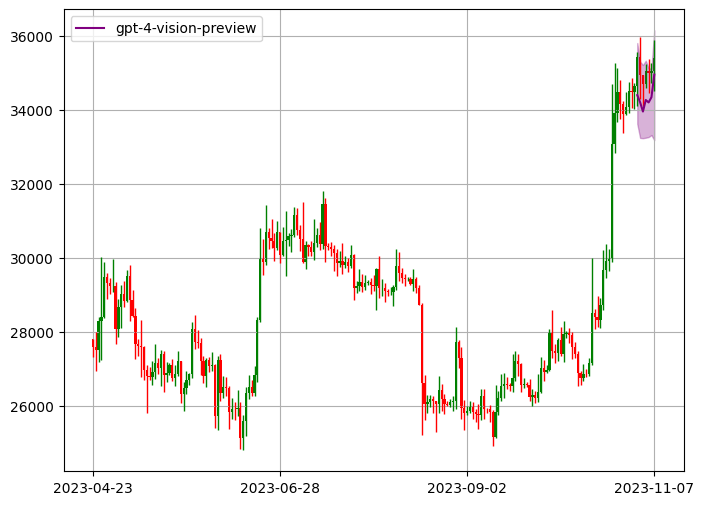

In [41]:
ending_predict_date = '2023-11-01'
ending_dates = ['2023-11-04', '2023-11-06', '2023-11-08']
index_save = 0
savefig = "return/"

dict_error_return = {"input_length" : {6: {"Mae": None, "Mse": None},
                                12: {"Mae": None, "Mse": None},
                                24: {"Mae": None, "Mse": None},
                                48: {"Mae": None, "Mse": None},
                                96: {"Mae": None, "Mse": None},
                                192: {"Mae": None, "Mse": None}}}

for input_length in [6, 12, 24, 48, 96, 192] :

    ending_predict_date_num = datetime.strptime(ending_predict_date, '%Y-%m-%d')
    new_date = ending_predict_date_num - timedelta(days=input_length)

    start_date = new_date.strftime('%Y-%m-%d')
    end_date = ending_dates[-1]

    df_raw, train, test = get_data_set_return("datasets/BTC_Daily_ohlc.csv", input_length, start_date, end_date)
    input_str = str_convert(train.values)

    print("Input str : ", input_str)
    list_response = request_gpt(input_str)
    print("GPT Answer : ", list_response)

    final_dic_int_list = basic_seriealize(list_response)
    print("int list return")
    print(final_dic_int_list)
    
    final_dic = convert_return_to_close(final_dic_int_list, df_raw, input_length)
    print("int list, close")
    print(final_dic)

    full_Mae_dict, full_Mse_dict = MAE_MSE_calculator(final_dic, df_raw, input_length)
    dict_error_return["input_length"][input_length]["Mae"] = full_Mae_dict
    dict_error_return["input_length"][input_length]["Mse"] = full_Mse_dict

    with open('pickle/dic_error_return.pkl', 'wb') as fichier:
        pickle.dump(dict_error_return, fichier)

    index_save += 1
    current_folder = savefig + str(index_save)
    plot_preds_candles(df_raw, train, test, final_dic, "gpt-4-vision-preview", show_samples=False,  savefig = current_folder)

In [42]:
with open('pickle/dic_error_return.pkl', 'rb') as fichier:
    dict_error_return = pickle.load(fichier)
    
dic_error_3_return = {"input_length" : {6: {"Mae": None, "Mse": None},
                                12: {"Mae": None, "Mse": None},
                                24: {"Mae": None, "Mse": None},
                                48: {"Mae": None, "Mse": None},
                                96: {"Mae": None, "Mse": None},
                                192: {"Mae": None, "Mse": None}}}
dic_error_5_return = {"input_length" : {6: {"Mae": None, "Mse": None},
                                12: {"Mae": None, "Mse": None},
                                24: {"Mae": None, "Mse": None},
                                48: {"Mae": None, "Mse": None},
                                96: {"Mae": None, "Mse": None},
                                192: {"Mae": None, "Mse": None}}}
dic_error_7_return = {"input_length" : {6: {"Mae": None, "Mse": None},
                                12: {"Mae": None, "Mse": None},
                                24: {"Mae": None, "Mse": None},
                                48: {"Mae": None, "Mse": None},
                                96: {"Mae": None, "Mse": None},
                                192: {"Mae": None, "Mse": None}}}


dic_mgt(dict_error_return, dic_error_3_return, dic_error_5_return, dic_error_7_return)
print(dic_error_3_return)


{'input_length': {6: {'Mae': 492.67097032386937, 'Mse': 359534.7704967661}, 12: {'Mae': 898.1486648295412, 'Mse': 1805235.3300082537}, 24: {'Mae': 1146.567452950017, 'Mse': 2658072.436480111}, 48: {'Mae': 911.6203156811328, 'Mse': 1141228.7708818084}, 96: {'Mae': 1014.496211913863, 'Mse': 1443562.2455244556}, 192: {'Mae': 976.5020843360469, 'Mse': 1198775.5611244394}}}


In [46]:
table_display(dic_error_3_return)
table_display(dic_error_5_return)
table_display(dic_error_7_return)

  input_length       Mae               Mse
--------------  --------  ----------------
             6   492.671  359535
            12   898.149       1.80524e+06
            24  1146.57        2.65807e+06
            48   911.62        1.14123e+06
            96  1014.5         1.44356e+06
           192   976.502       1.19878e+06
  input_length       Mae               Mse
--------------  --------  ----------------
             6   653.714  773531
            12   927.361       1.87502e+06
            24  1436.74        3.82882e+06
            48  1153.34        3.09957e+06
            96  1002.84        1.50384e+06
           192   950.376       1.19471e+06
  input_length       Mae          Mse
--------------  --------  -----------
             6   940.873  2.04164e+06
            12  1027.74   2.18162e+06
            24  1772.83   6.45003e+06
            48  1759.08   8.43351e+06
            96   938.063  1.33974e+06
           192   933.99   1.20724e+06


Input str :  34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['D2, U2, U4, D2, U2, U4, D2', 'Based on the provided sequence, the numbers appear to be generally trending upwards with some fluctuations. Unfortunately, without knowing the specific numeric values to correlate with each bin, it is not possible to accurately predict the next seven bins in the sequence. Time series predictions typically require more context or data about the trend, seasonal variations, or other external factors influencing the changes. If you can provide further context or the specific rules for the bins, I can try to assist you in predicting the next seven bins.', 'To predict the next seven bins in the sequence, we first need to analyze the given sequence of prices to identify the trend changes between each price point:\n\n1. From 34152 to 33893: The price decreased by (34152 - 33893) / 34152 * 100% = ~0.758% (No bin matches as the decrease is less than 2%)\n2. From 33893 to 34081: The price increas

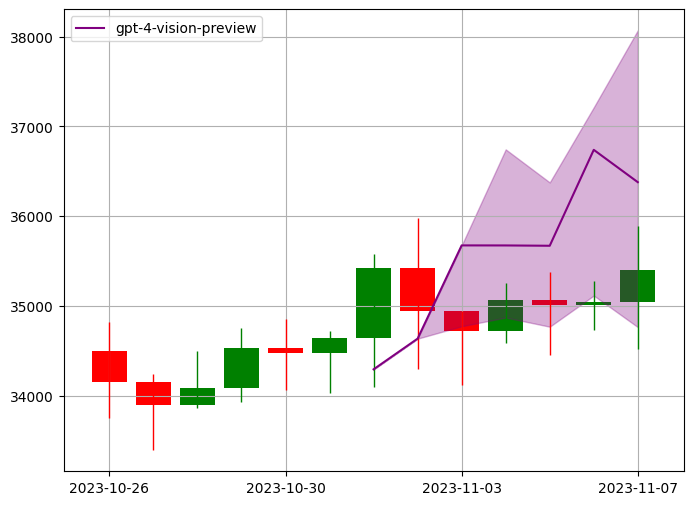

Input str :  29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['U2, U2, D2, D2, D4, D4, D6', 'D2, D4, D6, D8, D10, D10+, U2', 'D2, D4, D6, D8, D10, D10+, U2', 'D2, D2, D2, D2, D2, D2, D2', 'Assuming the given sequence represents the price changes and the user request is to predict the trend category for the next seven price points following the defined bins criteria:\n\nTo continue the sequence, we must first calculate the percentage change of each number from one to the next and then categorize each change according to the provided bins "D10+", "D10", "D8", "D6", "D4", "D2", "U2", "U4", "U6", "U8", "U10", "U10+".\n\nLet\'s calculate the percentage changes step by step before making the predictions:\n\nThe percentage change from the last known price (34641) to the next price can be calculated when we have the next number in the sequence. Since we don\'t have further numbers, we can\'t calculate the actual percentages changes. Hence, we 

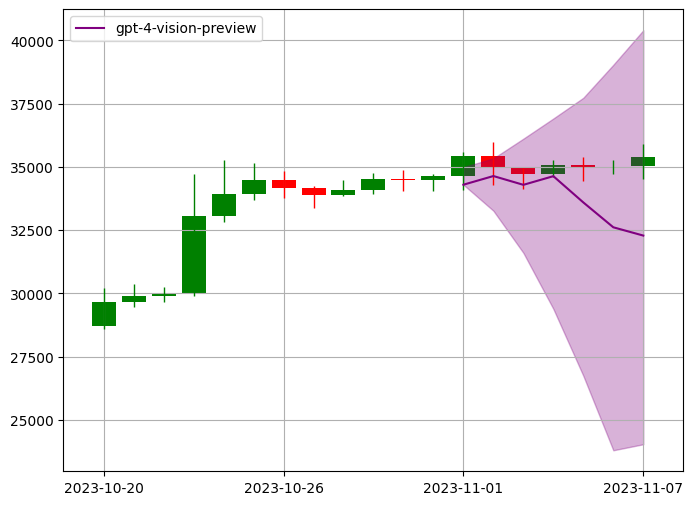

Input str :  27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['D2, U2, U4, U2, U2, U4, U2', 'D2, D2, U2, U2, U2, U2, U2', 'D2, D4, D6, D6, D4, D2, U2', 'D2, D4, D2, U2, U2, U2, U4', 'D2, U2, U4, U2, D2, D4, D6', "To predict the next seven bins in the sequence, we first need to calculate the percentage changes between each pair of values and identify which bin they fall into.\n\nLet's calculate the percentage changes:\n\n1. \\( \\frac{34641 - 34476}{34476} \\times 100 \\) = \\( \\frac{165}{34476} \\times 100 \\) ≈ 0.48% → U2\n\nNow we will predict the next seven percentage changes and assign the appropriate bins. Since predicting precise percentage changes for future data points is a complex task often requiring comprehensive historical data and analysis, we will assume that past trends may give us a general idea of future movement direction.\n\nWe have 

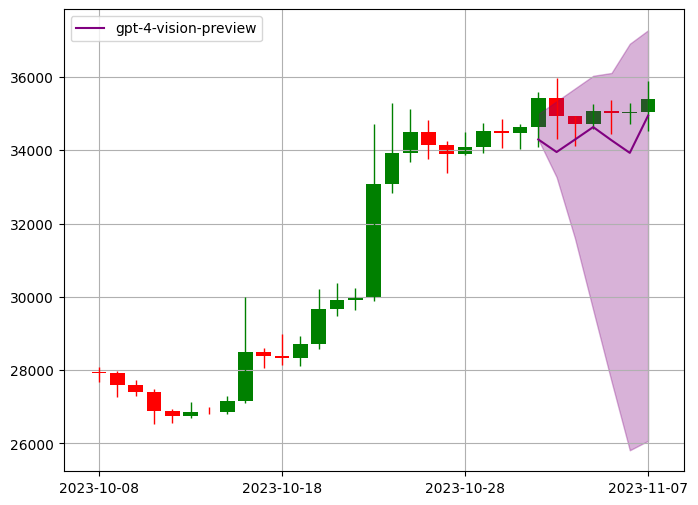

Input str :  26523, 26600, 26560, 26528, 26763, 27210, 27125, 26568, 26580, 26576, 26248, 26304, 26221, 26372, 27022, 26907, 26963, 27993, 27495, 27427, 27779, 27411, 27932, 27957, 27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['U2, U2, D2, D4, D6, D6, U2', 'D2, D2, U2, D2, U2, U2, U2', 'D2, U2, U2, U2, U4, U4, U6', 'D2, D4, U2, U2, D2, U2, U2', 'D2, D4, D2, U2, U2, D2, D2', 'D2, U2, D2, D4, D2, D4, D6', 'D2, U2, U4, D4, D6, D8, D10', 'D2, U2, U2, U2, D2, D4, D6', 'D2, U2, D4, D2, U2, D2, D4', 'U2, U2, U2, U4, U4, U6, U8']
serialized :  [[1, 1, -1, -3, -5, -5, 1], [-1, -1, 1, -1, 1, 1, 1], [-1, 1, 1, 1, 3, 3, 5], [-1, -3, 1, 1, -1, 1, 1], [-1, -3, -1, 1, 1, -1, -1], [-1, 1, -1, -3, -1, -3, -5], [-1, 1, 3, -3, -5, -7, -9], [-1, 1, 1, 1, -1, -3, -5], [-1, 1, -3, -1, 1, -1, -3], [1, 1, 1, 3, 3, 5, 7]]
int list, close
[[34987, 35336, 34982, 33932, 32235, 

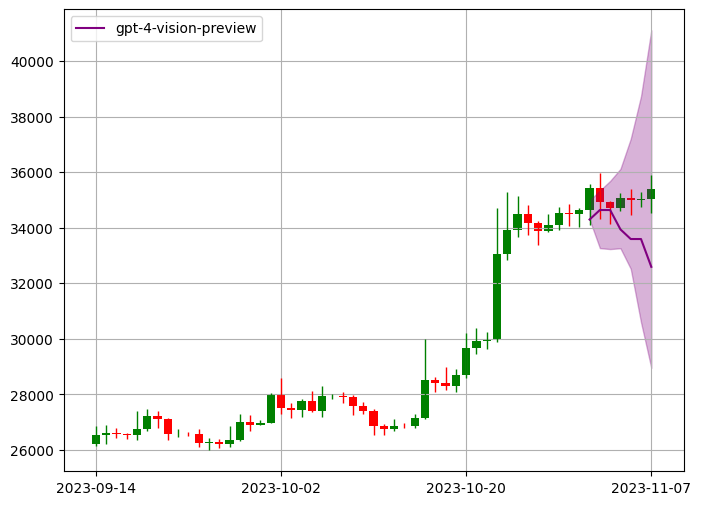

Input str :  29314, 29353, 29281, 29232, 29706, 29185, 29193, 29112, 29071, 29087, 29210, 29770, 29581, 29454, 29425, 29430, 29303, 29430, 29199, 28729, 26624, 26054, 26100, 26190, 26127, 26055, 26433, 26179, 26059, 26017, 26101, 26119, 27717, 27300, 25940, 25805, 25870, 25971, 25826, 25792, 25759, 26254, 25910, 25902, 25841, 25162, 25840, 26222, 26523, 26600, 26560, 26528, 26763, 27210, 27125, 26568, 26580, 26576, 26248, 26304, 26221, 26372, 27022, 26907, 26963, 27993, 27495, 27427, 27779, 27411, 27932, 27957, 27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['D2, D4, D6, D8, D10, D10+, D10+', 'U2, U2, U2, D2, D2, D2, U2', 'D2, D4, D6, D8, D10, D10+, U2', 'D2, U2, D2, U2, D4, D4, D6', 'U2, U2, D2, D2, U2, U2, U4', 'To continue the sequence predicting the upcoming trend bins, we first need to analyze the percentage change between each pair of consecutive

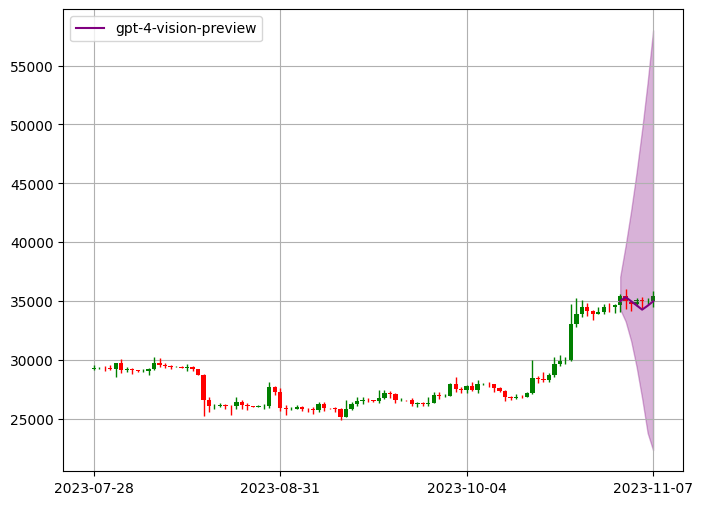

Input str :  27591, 27511, 28301, 28416, 29473, 29313, 29231, 29233, 28069, 28670, 29026, 28839, 29507, 28850, 28431, 27670, 27629, 27599, 26970, 26796, 26776, 26919, 27162, 27034, 27406, 26821, 26881, 27103, 26748, 26850, 27220, 26329, 26474, 26706, 26855, 28065, 27737, 27695, 27211, 26818, 27243, 27070, 27116, 25729, 27230, 26340, 26499, 26478, 25842, 25926, 25905, 25934, 25129, 25597, 26344, 26517, 26340, 26844, 28308, 29995, 29885, 30690, 30528, 30463, 30268, 30693, 30077, 30447, 30472, 30586, 30617, 31156, 30767, 30505, 29896, 30345, 30285, 30161, 30412, 30622, 30380, 31455, 30313, 30290, 30233, 30139, 29860, 29910, 29800, 29902, 29794, 30084, 29177, 29229, 29352, 29223, 29314, 29353, 29281, 29232, 29706, 29185, 29193, 29112, 29071, 29087, 29210, 29770, 29581, 29454, 29425, 29430, 29303, 29430, 29199, 28729, 26624, 26054, 26100, 26190, 26127, 26055, 26433, 26179, 26059, 26017, 26101, 26119, 27717, 27300, 25940, 25805, 25870, 25971, 25826, 25792, 25759, 26254, 25910, 25902, 25841, 

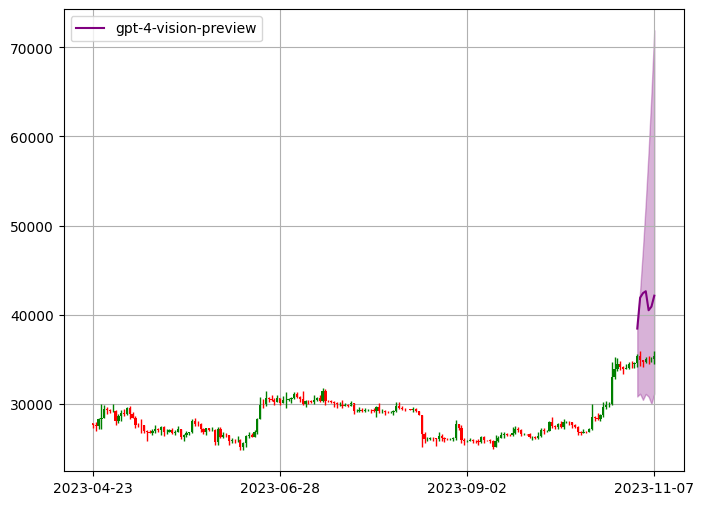

In [47]:
ending_predict_date = '2023-11-01'
ending_dates = ['2023-11-04', '2023-11-06', '2023-11-08']
index_save = 0
savefig = "bin/"


dict_error_bin = {"input_length" : {6: {"Mae": None, "Mse": None},
                                12: {"Mae": None, "Mse": None},
                                24: {"Mae": None, "Mse": None},
                                48: {"Mae": None, "Mse": None},
                                96: {"Mae": None, "Mse": None},
                                192: {"Mae": None, "Mse": None}}}

for input_length in [6, 12, 24, 48, 96, 192] :

    ending_predict_date_num = datetime.strptime(ending_predict_date, '%Y-%m-%d')
    new_date = ending_predict_date_num - timedelta(days=input_length)

    start_date = new_date.strftime('%Y-%m-%d')
    end_date = ending_dates[-1]

    df_raw, train, test = get_data_set("datasets/BTC_Daily_ohlc.csv", input_length, start_date, end_date)
    input_str = str_convert(train.values)

    print("Input str : ", input_str)
    list_response = request_gpt_bin(input_str)
    print("GPT Answer : ", list_response)

    final_dic_int_list = bin_seriealize(list_response)
    print("serialized : ", final_dic_int_list)

    final_dic = convert_bin_to_close(final_dic_int_list, df_raw, input_length)
    print("int list, close")
    print(final_dic)

    full_Mae_dict, full_Mse_dict = MAE_MSE_calculator(final_dic, df_raw, input_length)
    dict_error_bin["input_length"][input_length]["Mae"] = full_Mae_dict
    dict_error_bin["input_length"][input_length]["Mse"] = full_Mse_dict

    with open('pickle/dic_error_bin.pkl', 'wb') as fichier:
        pickle.dump(dict_error_bin, fichier)

    index_save += 1
    current_folder = savefig + str(index_save)
    plot_preds_candles(df_raw, train, test, final_dic, "gpt-4-vision-preview", show_samples=False, savefig= current_folder )




In [48]:
with open('pickle/dic_error_bin.pkl', 'rb') as fichier:
    dict_error_bin = pickle.load(fichier)

dic_error_3_bin = {"input_length" : {6: {"Mae": None, "Mse": None},
                                12: {"Mae": None, "Mse": None},
                                24: {"Mae": None, "Mse": None},
                                48: {"Mae": None, "Mse": None},
                                96: {"Mae": None, "Mse": None},
                                192: {"Mae": None, "Mse": None}}}
dic_error_5_bin = {"input_length" : {6: {"Mae": None, "Mse": None},
                                12: {"Mae": None, "Mse": None},
                                24: {"Mae": None, "Mse": None},
                                48: {"Mae": None, "Mse": None},
                                96: {"Mae": None, "Mse": None},
                                192: {"Mae": None, "Mse": None}}}
dic_error_7_bin = {"input_length" : {6: {"Mae": None, "Mse": None},
                                12: {"Mae": None, "Mse": None},
                                24: {"Mae": None, "Mse": None},
                                48: {"Mae": None, "Mse": None},
                                96: {"Mae": None, "Mse": None},
                                192: {"Mae": None, "Mse": None}}}


dic_mgt(dict_error_bin, dic_error_3_bin, dic_error_5_bin, dic_error_7_bin)
print(dic_error_3_bin)


{'input_length': {6: {'Mae': 775.0764943325115, 'Mse': 730575.0347343781}, 12: {'Mae': 1113.1384941897916, 'Mse': 1946828.8495473051}, 24: {'Mae': 1157.240522867811, 'Mse': 1882743.2752509522}, 48: {'Mae': 805.3647828693784, 'Mse': 869210.7332524788}, 96: {'Mae': 1785.7910657877826, 'Mse': 9997983.961079039}, 192: {'Mae': 5775.55293147106, 'Mse': 41622699.96220407}}}


In [49]:
table_display(dic_error_3_bin)
table_display(dic_error_5_bin)
table_display(dic_error_7_bin)

  input_length       Mae               Mse
--------------  --------  ----------------
             6   775.076  730575
            12  1113.14        1.94683e+06
            24  1157.24        1.88274e+06
            48   805.365  869211
            96  1785.79        9.99798e+06
           192  5775.55        4.16227e+07
  input_length       Mae               Mse
--------------  --------  ----------------
             6   831.621  879583
            12  1989.62        8.6533e+06
            24  1532.39        5.05924e+06
            48  1037.84        1.522e+06
            96  2789.96        2.96327e+07
           192  7142.09        7.77515e+07
  input_length       Mae          Mse
--------------  --------  -----------
             6   995.942  1.3366e+06
            12  3019.62   2.04968e+07
            24  1924.85   9.38993e+06
            48  1654.6    5.1377e+06
            96  4168.38   6.69851e+07
           192  8521.03   1.36751e+08
